In [1]:
import torch
import torch.nn as nn

cfg = {
    'frontend': [64,64,'M',128,128,'M',256,256,256,'M',512,512,512],
    'backend' : [512,512,512,256,128,64]
}

def make_layers(cfg_list, in_channels=3, dilation=False):
    layers = []
    for v in cfg_list:
        if v == 'M':
            layers.append(nn.MaxPool2d(2,2))
        else:
            d = 2 if dilation else 1
            layers += [
                nn.Conv2d(in_channels, v, kernel_size=3, padding=d, dilation=d),
                nn.ReLU(inplace=True)
            ]
            in_channels = v
    return nn.Sequential(*layers)

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        
        self.frontend = make_layers(cfg['frontend'], in_channels=3, dilation=False)
        self.backend  = make_layers(cfg['backend'], in_channels=512, dilation=True)
        self.output   = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output(x)
        return x   

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)

model_path = "models/CSRNet_best_2.pth" 
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()
print("Model B loaded successfully!")

Model B loaded successfully!


In [3]:
import cv2
import numpy as np

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
    return img


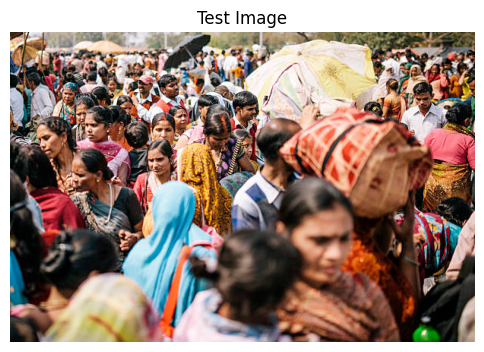

In [4]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("test.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Test Image")
plt.show()

In [5]:
img = cv2.imread("test.jpg")
input_tensor = preprocess(img).to(device)

with torch.no_grad():
    density = model(input_tensor)[0,0].cpu().numpy()
    count = density.sum()

print("Predicted Count:", count)

Predicted Count: 93.49958


In [6]:
video_path = "videos/Shopping, People, Commerce, Mall, Many, Crowd, Walking   Free Stock video footage   YouTube.mp4"

cap = cv2.VideoCapture(video_path)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imshow("Test Video", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [7]:
import numpy as np
import cv2
import torch

# Normalization values for CSRNet / VGG16
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def preprocess_frame(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)
    return torch.tensor(img, dtype=torch.float32).unsqueeze(0)

def overlay_heatmap(frame, density):
    density = density / (density.max() + 1e-6)
    density = (density * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(density, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))
    return cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)


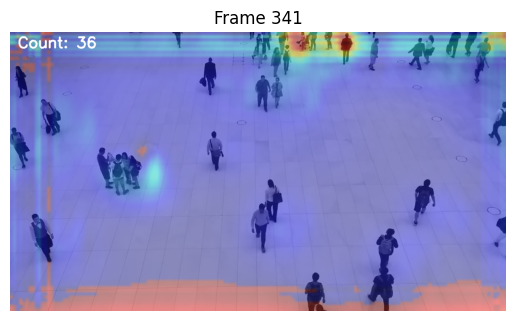

Video processing complete!


In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

video_path = "videos/Shopping, People, Commerce, Mall, Many, Crowd, Walking   Free Stock video footage   YouTube.mp4"   
cap = cv2.VideoCapture(video_path)

frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1

    # preprocess
    input_tensor = preprocess_frame(frame).to(device)

    # prediction
    with torch.no_grad():
        density = model(input_tensor)[0, 0].cpu().numpy()
        count = density.sum()

    # overlay heatmap
    output_frame = overlay_heatmap(frame, density)

    # add text
    cv2.putText(output_frame, f"Count: {int(count)}",
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX,
                1.3, (255,255,255), 3)

    # display in notebook
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {frame_idx}")
    plt.axis("off")
    plt.show()

cap.release()
print("Video processing complete!")

In [9]:
cap = cv2.VideoCapture(0)   # 0 = default webcam

if not cap.isOpened():
    print("Webcam not detected")
    raise SystemExit

print("Webcam started! Press 'q' to exit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Frame not captured")
        break

    # Preprocess
    input_tensor = preprocess_frame(frame).to(device)

    # Predict density map
    with torch.no_grad():
        density = model(input_tensor)[0, 0].cpu().numpy()
        count = density.sum()

    # Create heatmap overlay
    heatmap_frame = overlay_heatmap(frame, density)

    # Add count
    cv2.putText(heatmap_frame, f"Count: {int(count)}",
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX,
                1.2, (255,255,255), 3)

    # Display live window
    cv2.imshow("CSRNet Crowd Counting - Live Webcam", heatmap_frame)

    # Exit on Q key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Webcam stopped.")

Webcam started! Press 'q' to exit.
Webcam stopped.
